In [51]:
import sys
import time
from datetime import datetime
from xmljson import badgerfish as bf
from xml.etree.ElementTree import fromstring
from json import dumps
import operator
import numpy as np
import math
from collections import namedtuple
from scipy.interpolate import splprep, splev
from math import radians, cos, sin, asin, sqrt
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
try:
    from itertools import imap
except:
    imap = map
import matplotlib.pyplot as plt
from haversine import *
    

# Analysis of GPX files
#
#      Copyright 2021 
#      Juan M. Huerta 
#      
# dependencies: haversine, matplotlib, scipy 

## https://raven-endurance.com

###  This version includes GPX files with time stamps


In [39]:

#  Basic functions:

def load_gpx(file_location):
    trkpt = namedtuple('trkpt', 'lat lon ele time')   
    my_data = eval(dumps(bf.data(fromstring(open(file_location,'rt').read()))))
    a='{http://www.topografix.com/GPX/1/1}'
    trk=[]
    origin=None
    for p in my_data[a+"gpx"][a+"trk"][a+"trkseg"][a+"trkpt"]:
        trk.append(trkpt(float(p['@lat']), float(p['@lon']),float(p[a+"ele"]['$']), datetime.strptime(p[a+"time"]['$'], '%Y-%m-%dT%H:%M:%SZ')))
    return trk

def total_length(trk):
    old_gpx_point =trk[0]
    cum_dist=0
    for gpx_point in trk:
        #delta=my_haversine(gpx_point,old_gpx_point)
        delta=1000*haversine((gpx_point.lat,gpx_point.lon),(old_gpx_point.lat,old_gpx_point.lon))
        cum_dist+=delta
        old_gpx_point=gpx_point
    return cum_dist

def total_climbing(trk):
    old_gpx_point=trk[0]
    cum_dist=0
    for gpx_point in trk:
        delta= gpx_point.ele - old_gpx_point.ele
        cum_dist+=(delta if delta>0 else 0)
        old_gpx_point=gpx_point
    return cum_dist

def steepest_point_slope(trk):
    old_gpx_point = trk[0]
    largest_positive=0
    largest_negative=0
    for gpx_point in trk:
        if gpx_point != old_gpx_point:
            slope= (gpx_point.ele - old_gpx_point.ele)/(1000*haversine((gpx_point.lat,gpx_point.lon),(old_gpx_point.lat,old_gpx_point.lon)))
            if slope > largest_positive:
                largest_positive =slope
            if slope < largest_negative:
                largest_negative = slope
            old_gpx_point=gpx_point
    return largest_negative, largest_positive

def theil_sen_slope_estimator(trk):
    slopes=[]
    for i in range(len(trk)):
        for i2 in range(len(trk)-i-1):
            gpx_point_1=trk[i]
            gpx_point_2=trk[i+i2+1]
            if gpx_point_1 != gpx_point_2:
                slopes.append((gpx_point_2.ele - gpx_point_1.ele)/(1000*haversine((gpx_point_1.lat,gpx_point_1.lon),(gpx_point_2.lat,gpx_point_2.lon))))
            else:
                slopes.append(0)
    return np.median(slopes)


def x_v_curve(trk):
    old_gpx_point= trk[0]
    displacement=0
    x=[]
    v=[]
    for gpx_point in trk:
        incremental_displacement=1000*haversine((gpx_point.lat,gpx_point.lon),(old_gpx_point.lat,old_gpx_point.lon))
        displacement += incremental_displacement
        x.append(displacement)
        try:
            v.append(incremental_displacement/(gpx_point.time-old_gpx_point.time).total_seconds())
        except:
            #print("IM HERE",incremental_displacement,gpx_point.time-old_gpx_point.time)
            v.append(0)
        old_gpx_point=gpx_point
    return x,v



def x_y_curve(trk):
    old_gpx_point= trk[0]
    displacement=0
    x=[]
    y=[]
    for gpx_point in trk:
        displacement+=1000*haversine((gpx_point.lat,gpx_point.lon),(old_gpx_point.lat,old_gpx_point.lon))
        x.append(displacement)
        y.append(gpx_point.ele)
        old_gpx_point=gpx_point
    return x,y



def dedupe_consecutive(trk):
    deduped_trk=[]
    for x in trk:
        if deduped_trk ==[] or deduped_trk[-1]!=x:
            deduped_trk.append(x)
    return deduped_trk



Total Length in m: 54675.566558702485
Total Climbing in m: 542.5999999999945


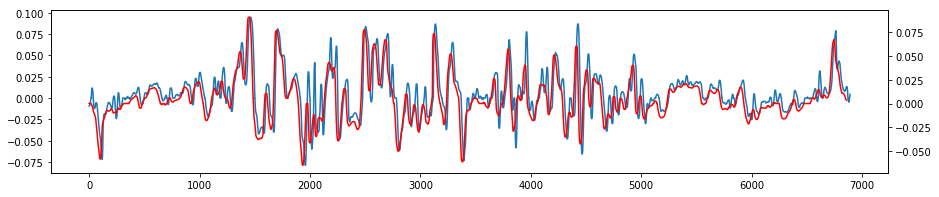

Theil Sen Steepest slopes (k=30): -0.07912719650317249 0.09504521311273781
Theil Sen Steepest slopes (k=60): -0.06483029258257357 0.09048197613596197


In [40]:

## PART 1

##  1. Download a gpx file, and provide its name (and path if it's not in notebook directory) to the load gpx_function

#my_trek=load_gpx('Toughman_NY_-_bike_leg.gpx')
#my_trek=load_gpx('Simpaug_Turnpike.gpx')
my_trek = load_gpx('Ride.gpx')

print("Total Length in m:",total_length(my_trek))
print("Total Climbing in m:",total_climbing(my_trek))
#print("Steepest point slopes:",steepest_slope(my_trek))
ts_slopes_30=[]
k=30
for i in range(len(my_trek)-k):
    ts_slopes_30.append(theil_sen_slope_estimator(my_trek[i:i+k-1]))

ts_slopes_60=[]
k=60
for i in range(len(my_trek)-k):
    ts_slopes_60.append(theil_sen_slope_estimator(my_trek[i:i+k-1]))

fig, ax1=plt.subplots(figsize=(15, 3))
ax1.plot(ts_slopes_30)
ax2=ax1.twinx()
ax2.plot(ts_slopes_60,color='r')

plt.show()
print("Theil Sen Steepest slopes (k=30):",min(ts_slopes_30),max(ts_slopes_30))
print("Theil Sen Steepest slopes (k=60):",min(ts_slopes_60),max(ts_slopes_60))

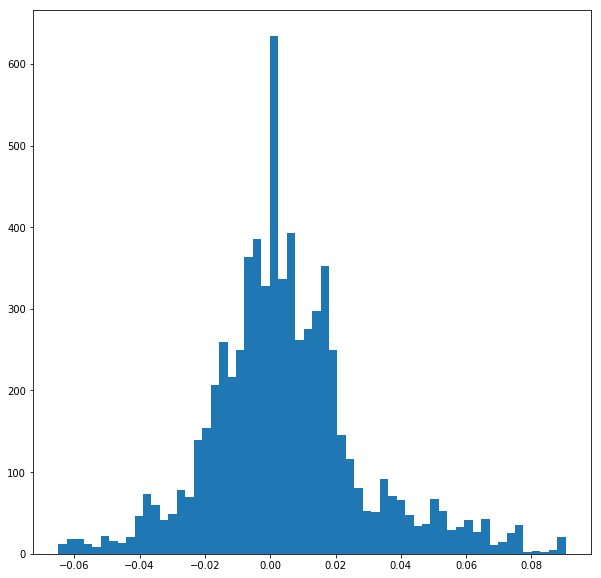

In [41]:

## Part 2

## This is the histogram of the Theil-Sen slopes

plt.figure(figsize=(10, 10))
plt.hist(ts_slopes_60, bins='auto')
plt.show()

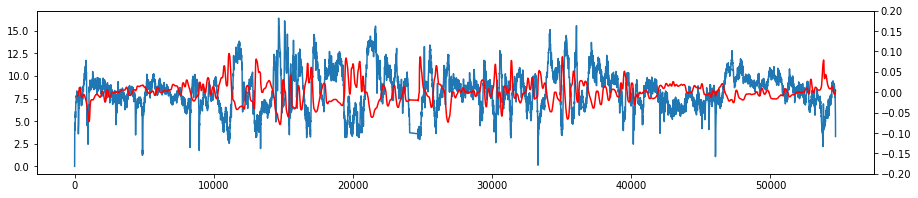

In [42]:

## Part 3.

## Plot together the velocity profile and the slope profile.

ts_slopes=ts_slopes_30
k=30
fig, ax1=plt.subplots(figsize=(15, 3))
x,v=x_v_curve(my_trek)
ax1.plot(x,v)
ax2=ax1.twinx()
ax2.plot(x[k:k+len(ts_slopes)],ts_slopes,color='r')
ax2.set_ylim([-.2, .2])
plt.show()


[5.09180497] [[1.72956841]] 0.22398704085397858
[7.91967184] [[1.29797269]] 0.5375058296590743
[10.10118407] [[3.1109545]] 0.2385071294869489


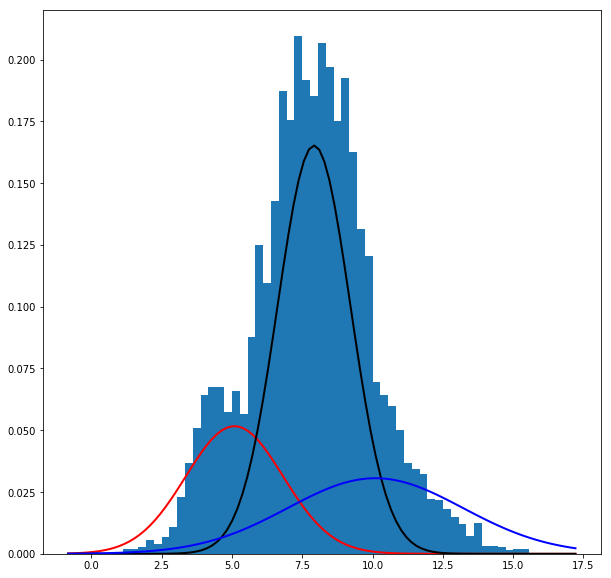

In [59]:
# Part 4

## This is the histogram of the velocities

plt.figure(figsize=(10, 10))
plt.hist(v, bins='auto', density = True)


GMM = GaussianMixture(n_components=3)
GMM.fit(np.array(v).reshape(-1,1))

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100).reshape(-1,1)
for component, color in zip(sorted(zip(GMM.means_,GMM.covariances_,GMM.weights_)),['r','k','b']):
    m, c, w = component
    print( m, c, w)
    p = w*norm.pdf(x, m, c)
    plt.plot(x, p, color, linewidth=2)

plt.show()


Norm: 0.9441205570773386


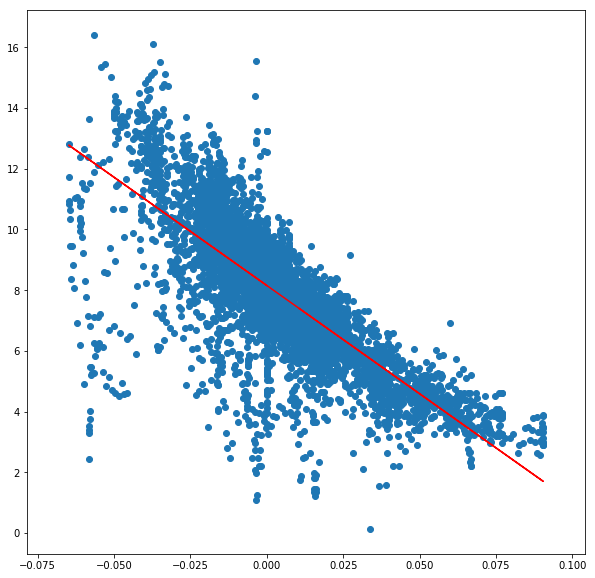

In [37]:
plt.figure(figsize=(10, 10))
shift =  int(60/2)+5

x=np.array(ts_slopes_60[:-shift])
y=np.array(v[shift:shift+len(x)])
plt.scatter(x,y)
m, b = np.polyfit(x, y, 1)
print("Norm:",(np.sqrt((np.array(m*x+b-y))**2.0).mean()))
plt.plot(x, m*x+b,color='r')
plt.show()

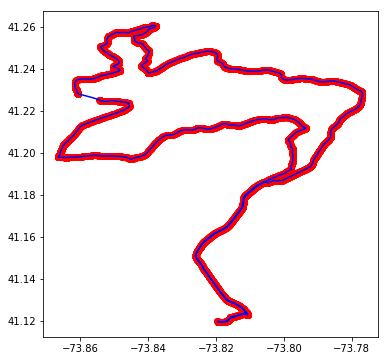

In [7]:
import warnings
warnings.filterwarnings('ignore')

## Part 5

## Provide a simple route plot (assuming lat-long are cartesian coordinates)

my_trek_deduped=dedupe_consecutive(my_trek)
pts = np.array([[x.lon, x.lat] for x in my_trek_deduped])

tck, u = splprep(pts.T, u=None, s=0.0, per=1) 
u_new = np.linspace(u.min(), u.max(), 1000)
x_new, y_new = splev(u_new, tck, der=0)
plt.figure(figsize=(6, 6))

plt.plot(pts[:,0], pts[:,1], 'ro')
plt.plot(x_new, y_new, 'b')
plt.show()

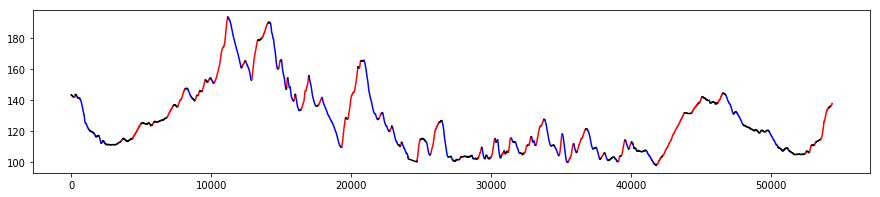

In [8]:

## Part 6

## Provide a color coded elevation profile plot: red for climbs, blue for descents, black for flat


ts_slopes=ts_slopes_30
k=30
ts_slopes_label=[]
x,y=x_y_curve(my_trek)
fig, ax1=plt.subplots(figsize=(15, 3))


for i in range(int(k-k/2)):
    ts_slopes_label.append('k')
    
for i in range(len(ts_slopes)):
    if ts_slopes[i]>0.01:
        ts_slopes_label.append('r')
    elif ts_slopes[i]<-0.01:
        ts_slopes_label.append('b')
    else:
        ts_slopes_label.append('k')

current_left=0
current_color='k'
current_index=0
for unit in zip(y,ts_slopes_label,x):
    if current_color != unit[1]:
        current_index+=1
        ax1.plot(x[current_left:current_index],y[current_left:current_index],color=current_color) 
        current_left=current_index
        current_color=unit[1]
    else:
        current_index+=1
        
plt.show()



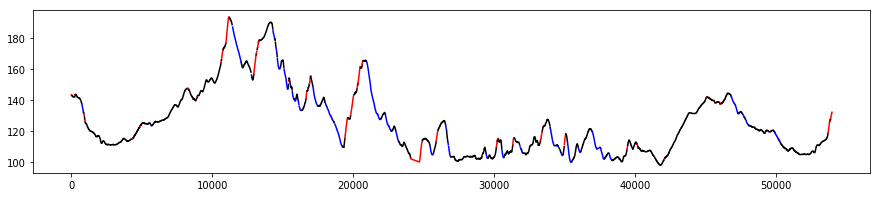

In [19]:
## Part 7

## Provide a color coded elevation profile plot:using speed for colors


ts_slopes=ts_slopes_30
k=30
ts_slopes_label=[]
x,y=x_y_curve(my_trek)
fig, ax1=plt.subplots(figsize=(15, 3))


ts_slopes_label.append('k')
    
for i in range(len(v)):
    if v[i]>10.0:
        ts_slopes_label.append('b')
    elif v[i]<5:
        ts_slopes_label.append('r')
    else:
        ts_slopes_label.append('k')

current_left=0
current_color='k'
current_index=0
for unit in zip(y,ts_slopes_label,x):
    if current_color != unit[1]:
        current_index+=1
        ax1.plot(x[current_left:current_index],y[current_left:current_index],color=current_color) 
        current_left=current_index
        current_color=unit[1]
    else:
        current_index+=1
        
plt.show()

